In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle

from utils import *

### Below are results from Goose_all_2

In [2]:
#selected subset of dates. 
val_dates = ['180328','180329']
test_dates = ['180330','180331']
load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_all_2/'

train_files, val_files, test_files = create_files(load_path, val_dates, test_dates)
train_loader, val_loader, test_loader = create_dataloaders(train_files, val_files, test_files,load_path, batch_size=256)

In [3]:
len(train_loader), len(val_loader), len(test_loader)

(223, 11, 25)

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim=100*10*62, output_dim=1):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 1, -1]).float()
        x1 = F.relu(self.linear1(x))
        outputs = self.linear2(x1)
        return outputs

In [ ]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'MLP'
loss_type = 'bce'
reg_type = 'none'
CH = 'all'

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Train loss for epoch {}: {}'.format(epoch, train_loss))
    val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    if val_losses:
        if val_loss < min(val_losses):
            best_epoch = epoch
            print(epoch)
            path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_1_upsample'
            torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, epoch))
    epochs.append(epoch)
    training_losses.append(train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    
    if train_loss < tol:
        break

Train loss for epoch 0: 5.637181758880615
Val loss for epoch 0: 1.0339089632034302
Train loss for epoch 1: 1.528361439704895
Val loss for epoch 1: 0.634041965007782
1
Train loss for epoch 2: 0.38548359274864197
Val loss for epoch 2: 0.4849734306335449
2
Train loss for epoch 3: 0.18208247423171997
Val loss for epoch 3: 0.4101341664791107
3
Train loss for epoch 4: 0.13340263068675995
Val loss for epoch 4: 0.3668285310268402
4
Train loss for epoch 5: 0.10207942128181458
Val loss for epoch 5: 0.34699487686157227
5
Train loss for epoch 6: 0.11003502458333969
Val loss for epoch 6: 0.45482730865478516
Train loss for epoch 7: 0.08611515164375305
Val loss for epoch 7: 0.33059871196746826
7
Train loss for epoch 8: 0.08065655827522278
Val loss for epoch 8: 0.595654308795929
Train loss for epoch 9: 0.08533122390508652
Val loss for epoch 9: 0.8833327889442444
Train loss for epoch 10: 0.09560886770486832
Val loss for epoch 10: 1.0663920640945435
Train loss for epoch 11: 0.08987785130739212
Val loss 

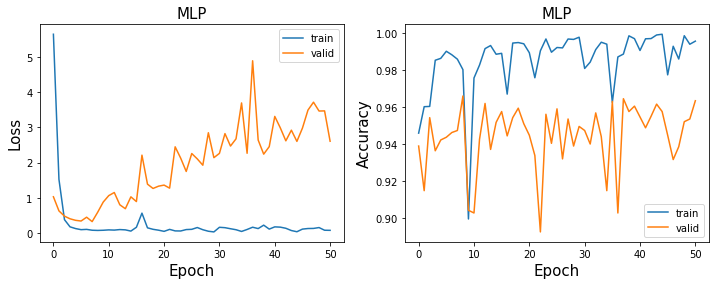

In [8]:
plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type)

In [10]:
model = MLP().to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_1_upsample'
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, best_epoch)))

<All keys matched successfully>

In [11]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{} accuracy:{}'.format(test_loss, test_acc))

test loss:0.48869988322257996 accuracy:0.936


In [12]:
path_wrong = '/mnt/pesaranlab/People/Capstone_students/Yue/wrong_pred'
pickle.dump(cases_wrong_0, open('{}/{}_CH{}_LOSS{}_REG{}{}.pt'.format(path_wrong, model_type, CH, loss_type, reg_type, alpha), 'wb'))

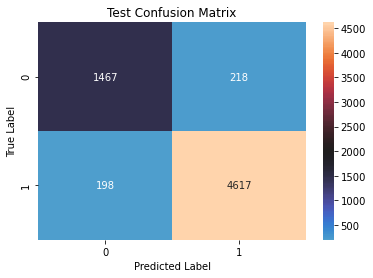

In [13]:
predictions_test = np.concatenate(test_preds)
labels_test = np.concatenate(test_labels)

df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

cm_test = confusion_matrix(labels_test, predictions_test)
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax, center=2000)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

### Goose_all_2 Results with different dropout

In [4]:
len(train_loader), len(val_loader), len(test_loader)

(223, 11, 25)

In [119]:
class MLP(nn.Module):
    def __init__(self, input_dim=100*10*62, output_dim=1, dropout = 0.5):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 1, -1]).float()
        x1 = self.dropout(self.relu(self.linear1(x)))
        outputs = self.linear2(x1)
        
        return outputs

In [121]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'MLP'
loss_type = 'bce'
reg_type = 'none'
CH = 'all'
dropout_all = [0,0.1,0.3,0.5,0.7,0.9,1]
model_saving_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_MLP'


Train loss for epoch 0: 3.863969326019287
Val loss for epoch 0: 0.3549734652042389
0
Train loss for epoch 1: 0.3801088333129883
Val loss for epoch 1: 0.1925644874572754
1
Train loss for epoch 2: 0.11176016926765442
Val loss for epoch 2: 0.12193810939788818
2
Train loss for epoch 3: 0.08990155905485153
Val loss for epoch 3: 0.16869404911994934
Train loss for epoch 4: 0.07930797338485718
Val loss for epoch 4: 0.23111829161643982
Train loss for epoch 5: 0.05937666445970535
Val loss for epoch 5: 0.18407677114009857
Train loss for epoch 6: 0.06846101582050323
Val loss for epoch 6: 0.1836991310119629
Train loss for epoch 7: 0.057612624019384384
Val loss for epoch 7: 0.17059406638145447
Train loss for epoch 8: 0.049328502267599106
Val loss for epoch 8: 0.32236823439598083
Train loss for epoch 9: 0.05701848864555359
Val loss for epoch 9: 0.2182769775390625
Train loss for epoch 10: 0.06639715284109116
Val loss for epoch 10: 0.439736932516098
Train loss for epoch 11: 0.06855638325214386
Val loss

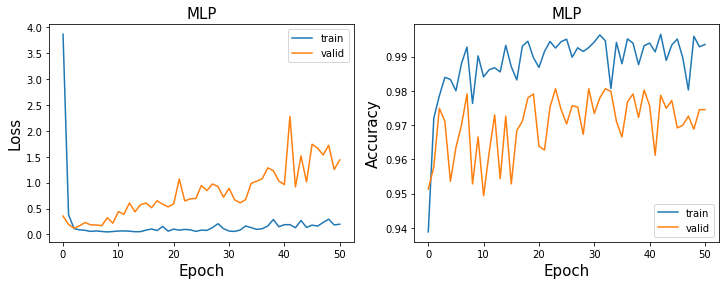

Train loss for epoch 0: 4.721159934997559
Val loss for epoch 0: 0.6514188647270203
0
Train loss for epoch 1: 1.4783302545547485
Val loss for epoch 1: 0.2860109806060791
1
Train loss for epoch 2: 0.4352138936519623
Val loss for epoch 2: 0.23089389503002167
2
Train loss for epoch 3: 0.15703031420707703
Val loss for epoch 3: 0.17662596702575684
3
Train loss for epoch 4: 0.11326763778924942
Val loss for epoch 4: 0.18044759333133698
Train loss for epoch 5: 0.11228117346763611
Val loss for epoch 5: 0.14209654927253723
5
Train loss for epoch 6: 0.08295711129903793
Val loss for epoch 6: 0.18238729238510132
Train loss for epoch 7: 0.09141683578491211
Val loss for epoch 7: 0.1732787936925888
Train loss for epoch 8: 0.07933800667524338
Val loss for epoch 8: 0.19400599598884583
Train loss for epoch 9: 0.083985336124897
Val loss for epoch 9: 0.29456827044487
Train loss for epoch 10: 0.0886094719171524
Val loss for epoch 10: 0.22518831491470337
Train loss for epoch 11: 0.09246514737606049
Val loss f

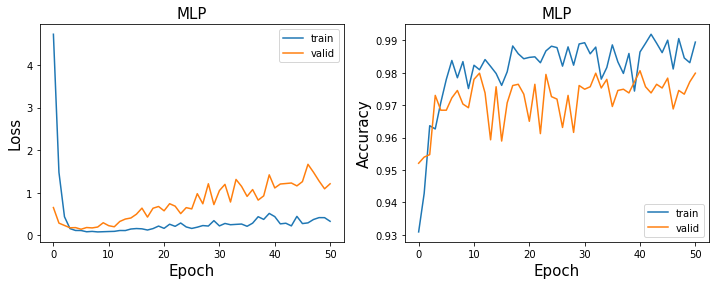

Train loss for epoch 0: 5.489307403564453
Val loss for epoch 0: 0.7494555115699768
0
Train loss for epoch 1: 2.022015333175659
Val loss for epoch 1: 0.6607033014297485
1
Train loss for epoch 2: 1.7298145294189453
Val loss for epoch 2: 0.46858686208724976
2
Train loss for epoch 3: 1.3403149843215942
Val loss for epoch 3: 0.3395664095878601
3
Train loss for epoch 4: 0.8208373785018921
Val loss for epoch 4: 0.228501558303833
4
Train loss for epoch 5: 0.4874345660209656
Val loss for epoch 5: 0.19157779216766357
5
Train loss for epoch 6: 0.2722482681274414
Val loss for epoch 6: 0.16065092384815216
6
Train loss for epoch 7: 0.22579224407672882
Val loss for epoch 7: 0.16636361181735992
Train loss for epoch 8: 0.2332129329442978
Val loss for epoch 8: 0.16529585421085358
Train loss for epoch 9: 0.16804340481758118
Val loss for epoch 9: 0.1590849757194519
9
Train loss for epoch 10: 0.1970994621515274
Val loss for epoch 10: 0.2083997279405594
Train loss for epoch 11: 0.2014763355255127
Val loss f

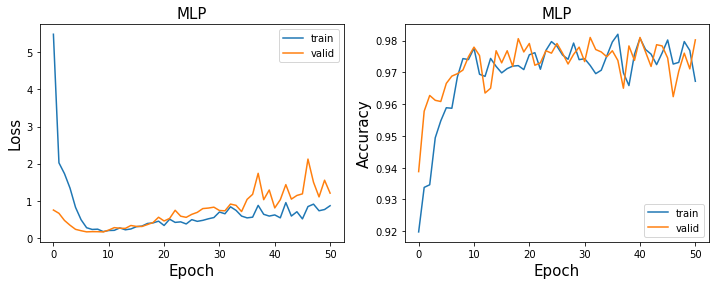

Train loss for epoch 0: 5.547114849090576
Val loss for epoch 0: 0.7596368193626404
0
Train loss for epoch 1: 2.7890660762786865
Val loss for epoch 1: 0.7785024046897888
Train loss for epoch 2: 2.3552005290985107
Val loss for epoch 2: 0.6564843654632568
2
Train loss for epoch 3: 2.2834157943725586
Val loss for epoch 3: 0.6057900786399841
3
Train loss for epoch 4: 2.3506109714508057
Val loss for epoch 4: 0.6363792419433594
Train loss for epoch 5: 2.2469170093536377
Val loss for epoch 5: 0.7212848663330078
Train loss for epoch 6: 2.2301878929138184
Val loss for epoch 6: 0.7223571538925171
Train loss for epoch 7: 2.186490058898926
Val loss for epoch 7: 0.6848968863487244
Train loss for epoch 8: 2.2061734199523926
Val loss for epoch 8: 0.903590202331543
Train loss for epoch 9: 2.1597487926483154
Val loss for epoch 9: 0.7130448818206787
Train loss for epoch 10: 2.462967872619629
Val loss for epoch 10: 0.7512739300727844
Train loss for epoch 11: 2.269906759262085
Val loss for epoch 11: 0.7700

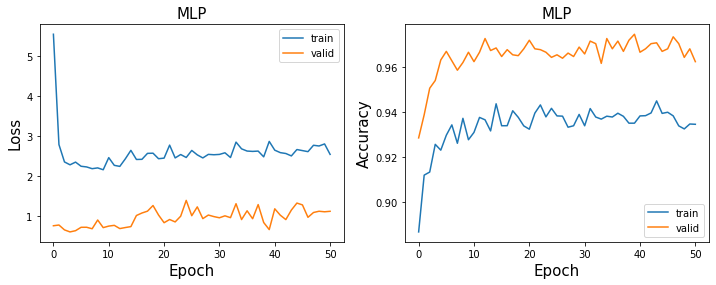

Train loss for epoch 0: 9.367510795593262
Val loss for epoch 0: 1.2188994884490967
0
Train loss for epoch 1: 4.552394390106201
Val loss for epoch 1: 1.0483750104904175
1
Train loss for epoch 2: 4.396058559417725
Val loss for epoch 2: 0.9493584632873535
2
Train loss for epoch 3: 4.3023681640625
Val loss for epoch 3: 0.8959974050521851
3
Train loss for epoch 4: 4.117527961730957
Val loss for epoch 4: 0.8882222175598145
4
Train loss for epoch 5: 4.185491561889648
Val loss for epoch 5: 0.8669664859771729
5
Train loss for epoch 6: 4.1439924240112305
Val loss for epoch 6: 1.0347976684570312
Train loss for epoch 7: 4.407973766326904
Val loss for epoch 7: 0.9881781935691833
Train loss for epoch 8: 4.264082431793213
Val loss for epoch 8: 1.015689492225647
Train loss for epoch 9: 4.255619049072266
Val loss for epoch 9: 0.950267493724823
Train loss for epoch 10: 4.362430095672607
Val loss for epoch 10: 1.0250706672668457
Train loss for epoch 11: 4.366203784942627
Val loss for epoch 11: 0.95523715

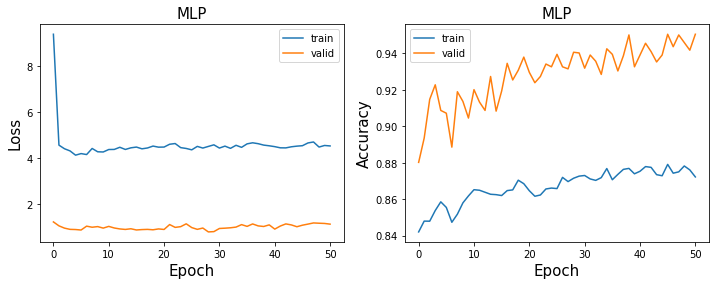

Train loss for epoch 0: 0.6906308531761169
Val loss for epoch 0: 0.8088273406028748
0
Train loss for epoch 1: 0.6889307498931885
Val loss for epoch 1: 0.8305745720863342
Train loss for epoch 2: 0.6887727379798889
Val loss for epoch 2: 0.8377031683921814
Train loss for epoch 3: 0.6887666583061218
Val loss for epoch 3: 0.8380967974662781
Train loss for epoch 4: 0.688765823841095
Val loss for epoch 4: 0.8410062193870544
Train loss for epoch 5: 0.6887711882591248
Val loss for epoch 5: 0.8391647338867188
Train loss for epoch 6: 0.6887747645378113
Val loss for epoch 6: 0.8415024280548096
Train loss for epoch 7: 0.6887621283531189
Val loss for epoch 7: 0.8383139371871948
Train loss for epoch 8: 0.6887643337249756
Val loss for epoch 8: 0.8392999768257141
Train loss for epoch 9: 0.6887624263763428
Val loss for epoch 9: 0.8406563401222229
Train loss for epoch 10: 0.6887680292129517
Val loss for epoch 10: 0.8406030535697937
Train loss for epoch 11: 0.6887646913528442
Val loss for epoch 11: 0.8409

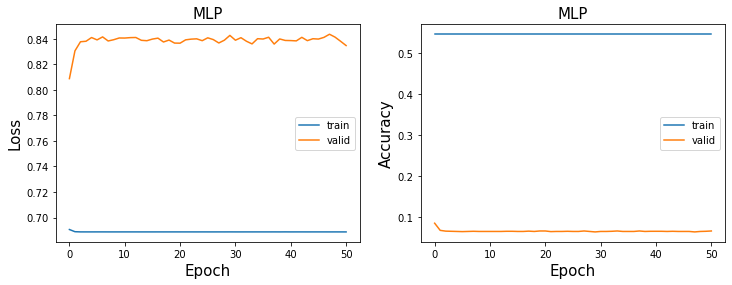

17590.65130496025


In [134]:
import time
start = time.time()
for d in range(0,len(dropout_all)):
    dropout = dropout_all[d]
    model = MLP(dropout = dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
        print('Train loss for epoch {}: {}'.format(epoch, train_loss))
        val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
        print('Val loss for epoch {}: {}'.format(epoch, val_loss))
        epochs.append(epoch)
        training_losses.append(train_loss)
        training_acc.append(train_acc)
        val_losses.append(val_loss)
        validation_acc.append(val_acc)
        if val_loss <= min(val_losses):
            best_epoch = epoch
            print(epoch)
            path = model_saving_path
            torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_DO{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, dropout, epoch))
    plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type)
end = time.time()

print(end-start)

In [135]:
model_MLP = os.listdir('/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_MLP')
results = []
for x in range(0,len(model_MLP)):
    result = model_MLP[x].split('_') 
    dropout = [int(i) for i in result[4] if i.isdigit()]
    if len(dropout) ==2:
        dropout = dropout[1]/10
    else:
        dropout = dropout[0]
    res = [int(i) for i in result[5] if i.isdigit()]
    res = int(res[0])
    results.append([dropout, res])

results = pd.DataFrame(np.array(results), columns=['dropout', 'epoch'])
best_results = results.groupby('dropout').max(epoch)
print(best_results)


         epoch
dropout       
0.1        2.0
0.3        5.0
0.5        9.0
0.7        3.0
0.9        5.0
1.0        3.0


In [136]:
model

MLP(
  (linear1): Linear(in_features=62000, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=1, inplace=False)
)

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_MLP/MLP_CHall_LOSSbce_REGnone0_DO0.1_EPOCH2.pt
test loss:0.18260006606578827 accuracy:0.9523123699791967


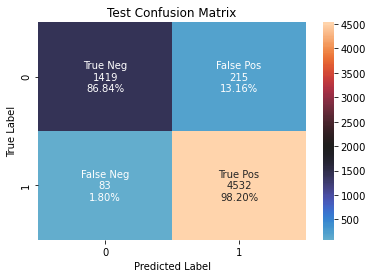

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_MLP/MLP_CHall_LOSSbce_REGnone0_DO0.3_EPOCH5.pt
test loss:0.2361403852701187 accuracy:0.9513522163546168


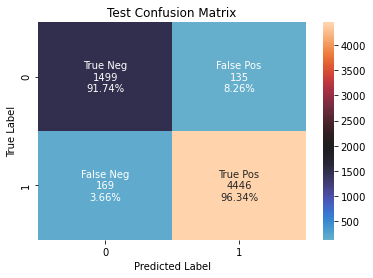

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_MLP/MLP_CHall_LOSSbce_REGnone0_DO0.5_EPOCH9.pt
test loss:0.2761150300502777 accuracy:0.957273163706193


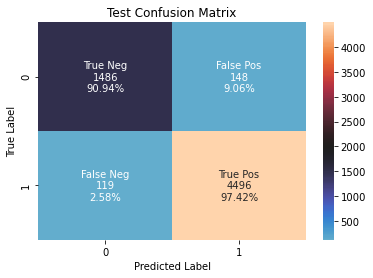

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_MLP/MLP_CHall_LOSSbce_REGnone0_DO0.7_EPOCH3.pt
test loss:1.1563687324523926 accuracy:0.9462313970235238


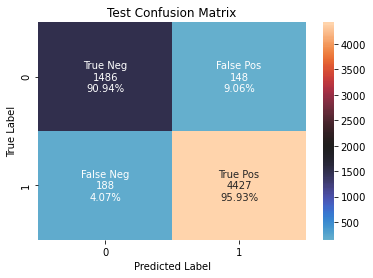

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_MLP/MLP_CHall_LOSSbce_REGnone0_DO0.9_EPOCH5.pt
test loss:2.061674118041992 accuracy:0.9257481196991518


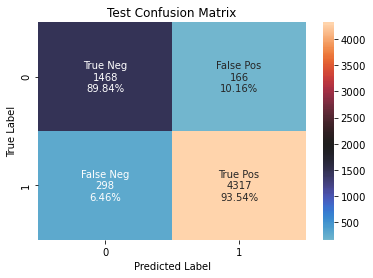

/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_all_2_MLP/MLP_CHall_LOSSbce_REGnone0_DO1_EPOCH3.pt
test loss:0.19632764160633087 accuracy:0.9567930868939031


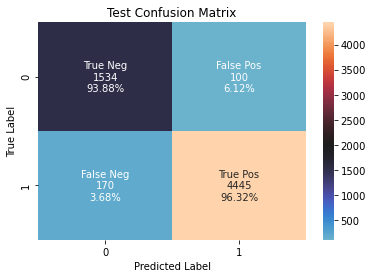

In [137]:
for i,(index,row) in enumerate(best_results.iterrows()):
    model = MLP().to(device)
    path = model_saving_path
    if index == 1.0:
        index = 1
    DO = index
    best_epoch = int(row)
    ## Load best model
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_DO{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha,DO, best_epoch)))
    print('{}/{}_CH{}_LOSS{}_REG{}{}_DO{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha,DO, best_epoch))
    
    ## Calculate accuracy and test loss
    test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))    
    
    ## Confusion matrix
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

### Dropout

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim=100*10*62, output_dim=1):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 1, -1]).float()
        x1 = self.dropout(self.relu(self.linear1(x)))
        outputs = self.linear2(x1)
        return outputs

In [11]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'MLP'
loss_type = 'bce'
reg_type = 'none'
CH = 'all'

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [12]:
epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Train loss for epoch {}: {}'.format(epoch, train_loss))
    val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_2_upsample'
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}_DROPOUT.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, epoch))

Train loss for epoch 0: 6.210958957672119
Val loss for epoch 0: 1.3904974460601807
0
Train loss for epoch 1: 2.8511769771575928
Val loss for epoch 1: 0.9024863839149475
1
Train loss for epoch 2: 2.6460137367248535
Val loss for epoch 2: 0.8673516511917114
2
Train loss for epoch 3: 2.5403270721435547
Val loss for epoch 3: 1.1848795413970947
Train loss for epoch 4: 2.3245315551757812
Val loss for epoch 4: 1.5877028703689575
Train loss for epoch 5: 2.385533332824707
Val loss for epoch 5: 1.2811344861984253
Train loss for epoch 6: 2.3153772354125977
Val loss for epoch 6: 1.1493852138519287
Train loss for epoch 7: 2.1970767974853516
Val loss for epoch 7: 1.6244819164276123
Train loss for epoch 8: 2.396665096282959
Val loss for epoch 8: 1.383778691291809
Train loss for epoch 9: 2.252708911895752
Val loss for epoch 9: 1.5159811973571777
Train loss for epoch 10: 2.6541333198547363
Val loss for epoch 10: 1.2681165933609009
Train loss for epoch 11: 2.313107490539551
Val loss for epoch 11: 1.38102

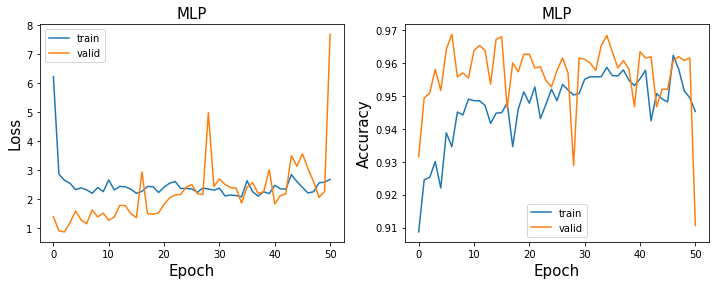

In [13]:
plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type)

In [15]:
model = MLP().to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_2_upsample'
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}_DROPOUT.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, best_epoch)))

<All keys matched successfully>

In [16]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{} accuracy:{}'.format(test_loss, test_acc))

test loss:1.6521267890930176 accuracy:0.9407905264842374


In [19]:
np.mean(np.concatenate(test_labels))

0.7385182

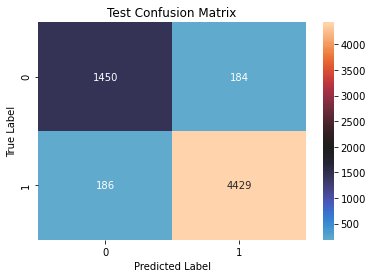

In [17]:
predictions_test = np.concatenate(test_preds)
labels_test = np.concatenate(test_labels)

df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

cm_test = confusion_matrix(labels_test, predictions_test)
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax, center=2000)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

### Reduction = 'sum'

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim=100*10*62, output_dim=1):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, 256)
        self.linear2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 1, -1]).float()
        x1 = self.relu(self.linear1(x))
        outputs = self.linear2(x1)
        return outputs

In [5]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.001
num_epochs = 51
alpha = 0
model_type = 'MLP'
loss_type = 'bce'
reg_type = 'none'
CH = 'all'

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Train loss for epoch {}: {}'.format(epoch, train_loss))
    val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)
    if val_loss <= min(val_losses):
        best_epoch = epoch
        print(epoch)
        path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_2_upsample'
        torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}_REDUCEsum.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, epoch))

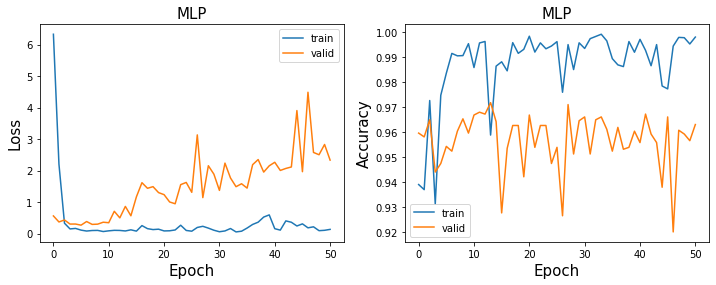

In [7]:
plot_loss_acc(training_losses, val_losses, training_acc, validation_acc, model_type)

In [8]:
best_epoch

5

In [9]:
model = MLP().to(device)
path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_2_upsample'
model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}_REDUCEsum.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, best_epoch)))

<All keys matched successfully>

In [10]:
test_loss, test_acc, test_preds, test_preds_probs, test_labels, cases_wrong_0 = evaluate(model, optimizer, test_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=True, device=device)
print('test loss:{} accuracy:{}'.format(test_loss, test_acc))

test loss:0.46965113282203674 accuracy:0.9455912946071371


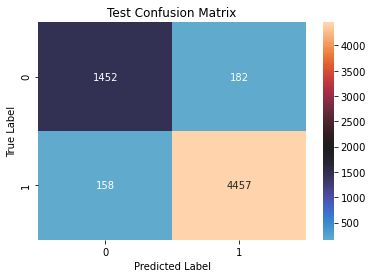

In [11]:
predictions_test = np.concatenate(test_preds)
labels_test = np.concatenate(test_labels)

df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

cm_test = confusion_matrix(labels_test, predictions_test)
ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax, center=2000)
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()